# Guided Project: Answering Business Questions using SQL

In this guided project, we practice using our SQL skills to answer business questions. In each step, we need to:

- Write a SQL query to extract the relevant data
- Create plots where necessary to visualize the data
- Write a short paragraph, drawing conclusions and explaining the data and/or visualizations.

We will continue to use the Chinook database that we have previously used. The Chinook database is provided as a SQLite database file called `chinook.db`. A copy of the database schema is below:

![chinook db schema](chinook-schema.svg)

---

## Helper Functions

We will use Python's [SQLite module](https://docs.python.org/3/library/sqlite3.html) and Pandas to write queries that produced dataframe outputs. The advantage of dataframe outputs is that they will display as tables in Jupyter notebook. We can also take advantage of pandas plotting methods to easily create visualizations of our tables inside our Jupyter notebook.

The [visualization section of the pandas docs](https://pandas.pydata.org/pandas-docs/stable/visualization.html) will be useful - we encourage you to have a look and see if you can use a few plot types that you might not have already used before.

Previously, we used the [`sqlite3.connect()` function](https://docs.python.org/3/library/sqlite3.html#sqlite3.connect) to create a connection object, and passed that to the [`pandas.read_sql_query()` function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_query.html). In this project, we will use a similar approach, with two important changes:

- We create some helper functions in python to save some time.
- We use a **context manager** to handle the connection to the SQLite database.

Context managers make our life easy by taking care of opening and closing the connection to the database, as well as making sure we don't accidentally make changes to the database if one of our queries has an error. For learning more about context managers, read [this excellent article by Jeff Knupp](https://jeffknupp.com/blog/2016/03/07/python-with-context-managers/). We use [the `with` statement](https://docs.python.org/3/reference/compound_stmts.html#the-with-statement) to access the [context manager that's built-in to the SQLite module](https://docs.python.org/3/library/sqlite3.html#using-the-connection-as-a-context-manager):

```python
with sqlite3.connect('chinook.db') as conn:
    # we can now access `conn`
    # inside an indented block
    query_result = pd.read_sql(my_query, conn)
```

With a few extra lines, we can turn this code into a function:

```python
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
```

By returning the dataframe, we can just run our function as the last line of a Jupyter cell and it will print the results nicely for us.

We will also create a function to run SQL queries that don't return tables, like `CREATE VIEW`. In this instance, we don't need to use pandas, we can simply use the SQLite module's [`connection.execute()` method](https://docs.python.org/3/library/sqlite3.html#sqlite3.Cursor.execute):

```python
with sqlite3.connect('chinook.db') as conn:
    conn.isolation_level = None
    conn.execute(c)
```

The `conn.isolation_level = None` line above tells SQLite to autocommit any changes.

Lastly, we will make a function that uses our `run_query()` function to return a list of all tables and views in our databases - this is handy to quickly check the state of our database as we work:

```python
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");
```

In [1]:
# import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)

In [3]:
def run_command(command):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(command)

In [4]:
def show_tables():
    query = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(query)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


---

## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we have been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| **Artist Name** |	**Genre** |
|      :-         |    :-     |
| Regal	          | Hip-Hop   |
| Red Tone	      | Punk      |
| Meteor and the Girls | Pop  |
| Slim Jim Bites  | Blues     |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

We will need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

We can run the `run_query()` function twice. Once at the end of a cell to display the results, and then a second time to assign the output of yours to a variable name:

```python
genre_sales_usa = run_query(q)
```

We can then use the [`DataFrame.plot()` method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) or any of the other pandas plotting methods to produce your visualization.

Note that if you use the DataFrame.set_index() method before you create your plot, your axis labels will be automatically added to your plot as shown in this blogpost.

Lastly, we should write up a summary of our findings, and make a recommendation for the three artists whose albums we should purchase for the store.

In [6]:
# verification - know # of genres
q = '''
SELECT
    COUNT(DISTINCT(name)) num_genres
FROM genre;
'''
r = run_query(q)
r.head(10)

,num_genres
0,25


In [7]:
# query
albums_to_purchase = '''
WITH
    usa_tracks_sold AS
        (
        SELECT il.*
        FROM invoice_line il
        INNER JOIN invoice i ON il.invoice_id = i.invoice_id
        INNER JOIN customer c ON i.customer_id = c.customer_id
        WHERE c.country = 'USA'
        )

SELECT
    g.name genre,
    COUNT(uts.invoice_line_id) tracks_sold,
    (CAST(COUNT(uts.invoice_line_id) AS FLOAT) / 
        (SELECT COUNT(*) FROM usa_tracks_sold)) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t ON uts.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY genre
ORDER BY tracks_sold DESC
LIMIT 10
'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


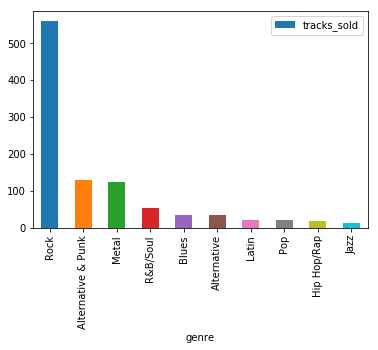

In [8]:
# Bar Plot
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", drop=True, inplace=True)
genre_sales_usa.plot.bar(y='tracks_sold')

plt.show()

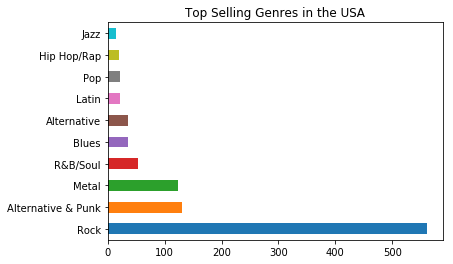

In [9]:
# Horizontal Bar Plot

genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", drop=True, inplace=True)
genre_sales_usa['tracks_sold'].plot.barh(
    title='Top Selling Genres in the USA'
)

plt.ylabel('')
plt.show()

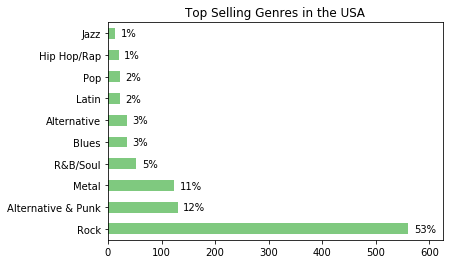

In [10]:
# Horizontal Bar Plot

genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", drop=True, inplace=True)

genre_sales_usa['tracks_sold'].plot.barh(
    title='Top Selling Genres in the USA',
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + '%'
    
    plt.annotate(label, (score + 10, i - 0.15))

plt.show()

**Observations**

Rock is by far the best selling genre in the USA accounting for over 50% of all sales. Alternative & Punk, and Metal are the next most popular genres accounting for 12% and 11% of all sales respectively.

We should purchase the following 3 artists' albums:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

Combined these three genres account for 17% of all USA track sales. We should look for Rock albums as that accounts for 53% of all USA track sales.

---

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. Let's analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [11]:
# query
employee_sales_performance = '''
WITH
    sales_per_customer AS
        (
        SELECT
            customer_id,
            SUM(total) total_purchases
        FROM invoice i
        GROUP BY customer_id
        )

SELECT
    (e.first_name || ' ' || e.last_name) employee,
    e.hire_date,
    SUM(spc.total_purchases) total_sales
FROM sales_per_customer spc
INNER JOIN customer c ON spc.customer_id = c.customer_id
INNER JOIN employee e ON c.support_rep_id = e.employee_id
GROUP BY employee
ORDER BY e.hire_date
'''
run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


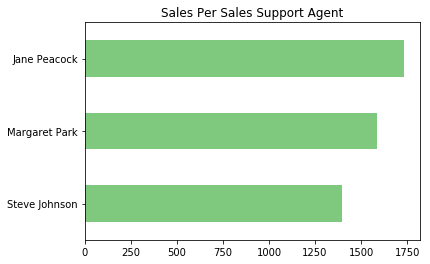

In [12]:
# Plot

employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values('total_sales', inplace=True)

employee_sales['total_sales'].plot.barh(
    title='Sales Per Sales Support Agent',
    colormap=plt.cm.Accent
)

plt.ylabel('')

plt.show()

**Observations**

There is a 20% difference between the highest and lowest sales per Sales Agent. This can be attributed to the 6 month gap in their hire dates (May 2017 vs. October 2017).

---

## Analyzing Sales by Country

Let's analyze the sales data for customers from each different country. In particular, let's look at:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [13]:
sales_by_country = '''
WITH
    customers_per_country AS
        (
            SELECT
                country,
                COUNT(customer_id) AS total_customers
            FROM customer
            GROUP BY 1
            ORDER BY 2 DESC
        ),
    sales_orders_per_customer AS
        (
            SELECT
                i.customer_id,
                c.country,
                COUNT(i.invoice_id) AS orders,
                SUM(total) AS total_sales
            FROM invoice i
            INNER JOIN customer c ON i.customer_id = c.customer_id
            GROUP BY 1
        ),
    unique_country_sales AS
        (
            SELECT
                cpc.country AS unique_country,
                cpc.total_customers,
                SUM(sopc.orders) AS total_orders,
                SUM(sopc.total_sales) AS total_sales
            FROM customers_per_country cpc
            INNER JOIN sales_orders_per_customer sopc
                ON cpc.country = sopc.country
            GROUP BY 1
            ORDER BY 2 DESC
        ),
    country_sales AS
        (
            SELECT
                CASE
                    WHEN total_customers = 1 THEN 'Other'
                    ELSE unique_country
                END AS country,
                SUM(total_customers) AS total_customers,
                SUM(total_orders) AS total_orders,
                SUM(total_sales) AS total_sales
            FROM
                (
                SELECT
                    ucs.*,
                    CASE
                        WHEN total_customers = 1 THEN 1
                        ELSE 0
                    END AS sort
                FROM unique_country_sales ucs
                )
            GROUP BY country
            ORDER BY sort, total_sales DESC
        )

SELECT
    country,
    total_customers AS customers,
    total_sales,
    total_sales / total_orders AS average_order,
    total_sales / total_customers AS avg_sales_per_customer
FROM country_sales cs;
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,avg_sales_per_customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


---

## Visualizing Sales by Country

Let's create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

In [14]:
country_metrics = run_query(sales_by_country)

# remove 'Other' group
unique_country_metrics = country_metrics[
    country_metrics['country'] != 'Other']

unique_country_metrics

,country,customers,total_sales,average_order,avg_sales_per_customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000


In [15]:
country_metrics.set_index('country', drop=True, inplace=True)
unique_country_metrics.set_index('country', drop=True, inplace=True)

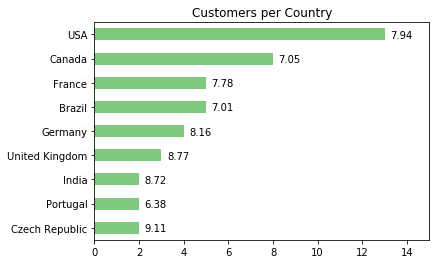

In [16]:
# Plot - Customers per Country

country_customers = unique_country_metrics.sort_values('customers')

country_customers['customers'].plot.barh(
    title='Customers per Country',
    colormap=plt.cm.Accent,
    xlim = (0, 15)
)

for i, label in enumerate(list(country_customers.index)):
    score = country_customers.loc[label, "customers"]
    label = country_customers.loc[label, "average_order"]
    label = f"{label:.2f}"
    
    #print(score, label, type(label))
    plt.annotate(label, (score + 0.25, i - 0.15))

plt.ylabel('')
plt.show()

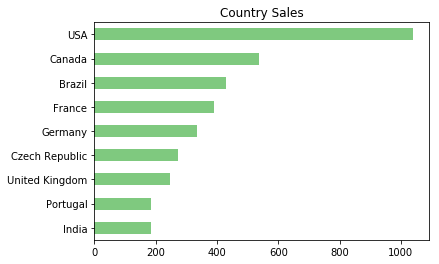

In [17]:
# Plot - Sales per Country

country_customers = unique_country_metrics.sort_values('total_sales')

country_customers['total_sales'].plot.barh(
    title='Country Sales',
    colormap=plt.cm.Accent,
)

#for i, label in enumerate(list(country_customers.index)):
#    score = country_customers.loc[label, 'total_sales']
#    label = country_customers.loc[label, "average_order"]
#    label = f"{label:.2f}"
#    
#    #print(score, label, type(label))
#    plt.annotate(label, (score + 1, i - 0.15))

plt.ylabel('')
plt.show()

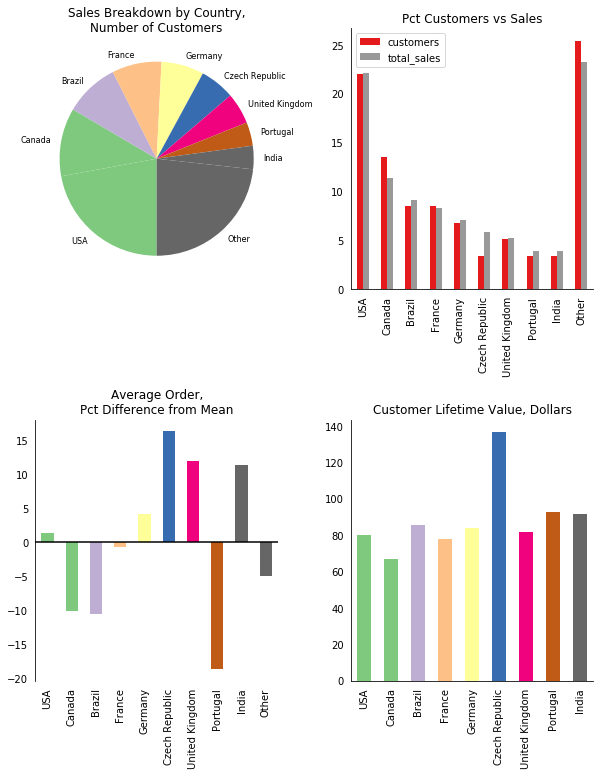

In [18]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index('country', drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in 
          np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 12))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# top left
sales_breakdown = country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    fontsize=8,
    colormap=plt.cm.Accent,
    wedgeprops={'linewidth':0},
)


# top right
cvd_cols = ['customers', 'total_sales']
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title='Pct Customers vs Sales'
)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# bottom left
avg_order = country_metrics['average_order'].copy()
avg_order.index.name = ''
difference_from_avg = (avg_order - avg_order.mean())/avg_order.mean() * 100
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title='Average Order,\nPct Difference from Mean'
)
ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.axhline(0, color='k')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)


# bottom right
aspc = country_metrics['avg_sales_per_customer'].copy()
aspc.index.name = ''

aspc.drop('Other', inplace=True)
aspc.plot.bar(
    ax=ax4,
    color=colors,
    title='Customer Lifetime Value, Dollars'
)
ax4.tick_params(top=False, right=False, left=False, bottom=False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.show()

**Observations**

There are opportunities to grow in the following countries:

- Czech Republic
- United Kingdom
- India

It should be noted that we don't have a lot of data from each country. Therefore we should be cautious about spending too much money on new marketing campaigns from this small sample size. We should run small campaigns in these countries, then collect and analyze the new customers.

---

## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when performing an analysis to have 'edge cases' which prevent us from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [49]:
# Attempt 1
albums_vs_tracks = '''
WITH
    album_tracks AS
        (
            SELECT
                a.album_id,
                a.title album,
                t.track_id,
                t.name track_name
            FROM album a
            INNER JOIN track t ON a.album_id = t.album_id
            ORDER BY 1
        ),
    albums AS
        (
            SELECT
                album,
                COUNT(track) track_count
            FROM
                (
                SELECT
                    a.album_id,
                    a.title album,
                    t.track_id,
                    t.name track
                FROM album a
                INNER JOIN track t ON a.album_id = t.album_id
                ORDER BY 1
                )
            GROUP BY 1
            HAVING track_count > 2
            ORDER BY 2 DESC
        ),
    invoice_tracks AS
        (
            SELECT
                i.invoice_id,
                t.track_id,
                t.name track_name,
                t.album_id album_id
            FROM invoice i
            INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
            INNER JOIN track t ON il.track_id = t.track_id
        ),
    invoice_first_track AS
        (
            SELECT
                il.invoice_id invoice_id,
                MIN(il.track_id) first_track_id
            FROM invoice_line il
            GROUP BY 1
        )


SELECT track_name
FROM invoice_tracks
EXCEPT
SELECT track_name
FROM album_tracks
'''
run_query(albums_vs_tracks)

,track_name


In [83]:
album_vs_tracks = '''
WITH
    invoice_first_track AS
        (
        SELECT
            il.invoice_id invoice_id,
            MIN(il.track_id) first_track_id
        FROM invoice_line il
        GROUP BY 1
        ),
    invoice_album_purchase AS
        (
        SELECT
            ifs.*,
            CASE
                WHEN
                    (
                    SELECT t.track_id FROM track t
                    WHERE t.album_id = (
                                        SELECT t2.album_id FROM track t2
                                        WHERE t2.track_id = ifs.first_track_id
                                       )

                    EXCEPT 

                    SELECT il2.track_id FROM invoice_line il2
                    WHERE il2.invoice_id = ifs.invoice_id
                    ) IS NULL
                AND
                    (
                    SELECT il2.track_id FROM invoice_line il2
                    WHERE il2.invoice_id = ifs.invoice_id

                    EXCEPT 

                    SELECT t.track_id FROM track t
                    WHERE t.album_id = (
                                        SELECT t2.album_id FROM track t2
                                        WHERE t2.track_id = ifs.first_track_id
                                        )
                    ) IS NULL
                THEN 'yes'
                ELSE 'no'
            END AS 'album_purchase'
        FROM invoice_first_track ifs
        )


SELECT
    iab.album_purchase,
    COUNT(iab.invoice_id) number_of_invoices,
    CAST(COUNT(iab.invoice_id) AS FLOAT) / (
                                                SELECT COUNT(*) FROM invoice
                                            ) percent
FROM invoice_album_purchase iab
GROUP BY album_purchase
'''
run_query(album_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


**Observations**

Over 80% of sales are non album purchases. We recommend against continuing to buy full albums from record companies.

---

## Next Steps

Here are a few business questions to explore next:

- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?

In the next mission, we'll learn more about table relations and normalization, including how to create and modify database tables.